In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#Note this noteboook makes use of the following data - this makes it more or less a test. Can be changed later.
time = np.load('times-year.npy')
particles = np.load('n-bound.npy')

def chi2(O,E):
    return np.sum(np.square(O - E) / E)

In [1]:
import os
print(os.getcwd())
print(os.path.isdir('images-MAcrit'))
os.chdir('..')
print(os.getcwd())
print(os.path.isdir('images-MAcrit'))

/home/vdvuurst/AMUSE/amuse-KL
False
/home/vdvuurst/AMUSE
True


## Fitting a power law in log-space

chi2 (log): 4.122875817469533


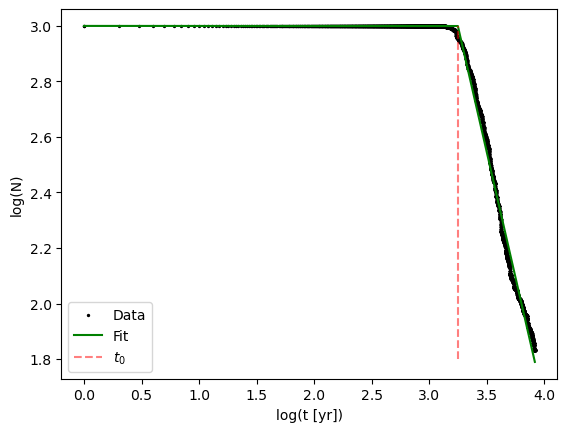

chi2 : 9896.981360788626


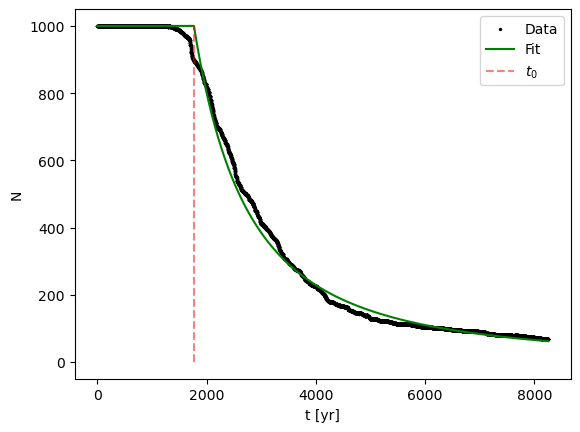

log(t0) = 3.2477797532015593 ± 0.0005652464514575599 ----> t_0 = 1769.2114981665657 ± 0.00130158079249406
alpha = -1.80927276460682 ± 0.0022464151310746293


In [7]:
time = np.load('times-year.npy')
particles = np.load('n-bound.npy')

# halflifemask = particles > 0.5*np.max(particles)
# particles = particles[halflifemask] #up until halving point
# time = time[halflifemask]

logtime = np.log10(time,where = time != 0) #where arg to avoid nans
logparticles = np.log10(particles)

################################################################################
# In case b is fittable (it shouldn't be since initial number of particles is known)

# def _linear_with_b(logt,t_0,alpha,b):
#     return alpha*(logt-t_0) + b

# def constant_linear_with_b(logt,t_0,alpha,b):
#     trel = logt - t_0 
#     constant = lambda x: np.full(x.shape,b) #x is time here
#     lin = lambda x: _linear_with_b(x,t_0,alpha,b)
#     function = np.piecewise(logt, [trel <= 0, trel > 0],[constant,lin])
#     return function

# popt,pcov = curve_fit(constant_linear_with_b,logtime,logparticles,p0=[logtime[1289],-1.7,3]) 

################################################################################

def _linear(logt,t_0,alpha):
    return alpha*(logt-t_0) + 3

def constant_linear(logt,t_0,alpha):
    trel = logt - t_0 
    constant = lambda x: np.full(x.shape,3) #x is time here
    lin = lambda x: _linear(x,t_0,alpha)
    function = np.piecewise(logt, [trel <= 0, trel > 0],[constant,lin])
    return function

popt,pcov = curve_fit(constant_linear,logtime,logparticles,p0=[logtime[1289],-1.7],maxfev=5000)

pred = constant_linear(logtime,*popt)

print(f'chi2 (log): {chi2(logparticles,pred)}')

plt.figure()
plt.scatter(logtime,logparticles,c='black',label='Data',s=2)
plt.plot(logtime,pred,label='Fit',c='Green')
plt.vlines(popt[0],1.8,3,colors='red',label=r'$t_0$',linestyles='dashed',alpha=0.5)
plt.legend()
plt.ylabel('log(N)')
plt.xlabel('log(t [yr])')
plt.show()

print(f'chi2 : {chi2(particles,10**pred)}')


plt.figure()
plt.scatter(time,particles,c='black',label='Data',s=2)
plt.plot(time,10**pred,label='Fit',c='Green')
plt.vlines(10**popt[0],0,1000,colors='red',label=r'$t_0$',linestyles='dashed',alpha=0.5)
plt.legend()
plt.ylabel('N')
plt.xlabel('t [yr]')
plt.show()

print(f"log(t0) = {popt[0]} ± {np.sqrt(pcov[0,0])} ----> t_0 = {10**popt[0]} ± {10**popt[0]*np.log(10)*pcov[0,0]}")
print(f"alpha = {popt[1]} ± {np.sqrt(pcov[1,1])}")
try:
    print(f"b = {popt[2]} ± {np.sqrt(pcov[2,2])}")
except IndexError:
    pass

## Fitting an exponential (not as good)

Chi2 : 134682.33479129148


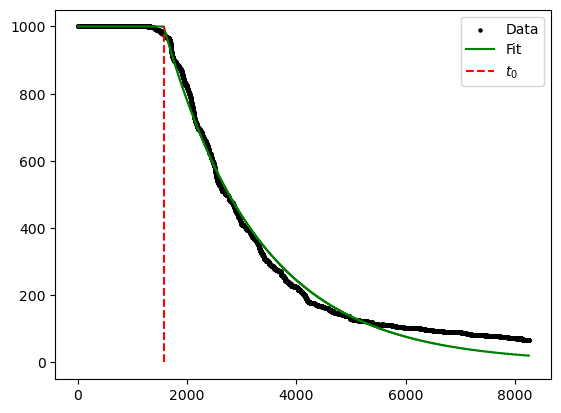

t0 = 1572.9008867518614 ± 2.284276553461934
tau = 1728.7089233763745 ± 3.258832542305948


In [3]:

def _exp_decay(t,t0,tau):
    return 1000 * np.exp( - (t - t0) / tau) + 0


def _const_exp_decay(t,t0,tau):
    trel = t - t0
    constant = lambda t: np.full(t.shape,1000)
    exp_function = lambda t: _exp_decay(t,t0,tau)
    function = np.piecewise(t, [trel <= 0, trel > 0],[constant,exp_function])
    return function

def exp_decay_fit(t,t0,tau):#for now we are not fitting on amp or offset
    return _const_exp_decay(t,t0,tau)

popt,pcov = curve_fit(exp_decay_fit,time,particles,maxfev=5000)

pred = _const_exp_decay(time,*popt)

print(f'Chi2 : {chi2(particles,pred)}')


plt.figure()
plt.scatter(time,particles,c='black',label='Data',s=5)
plt.plot(time,pred,label='Fit',c='Green')
plt.vlines(popt[0],0,1000,colors='red',label=r'$t_0$',linestyles='dashed')
plt.legend()
plt.show()

print(f"t0 = {popt[0]} ± {np.sqrt(pcov[0,0])}")
print(f"tau = {popt[1]} ± {np.sqrt(pcov[1,1])}")

### Without t0 as a fittable parameter

t0 = np.int64(1290)


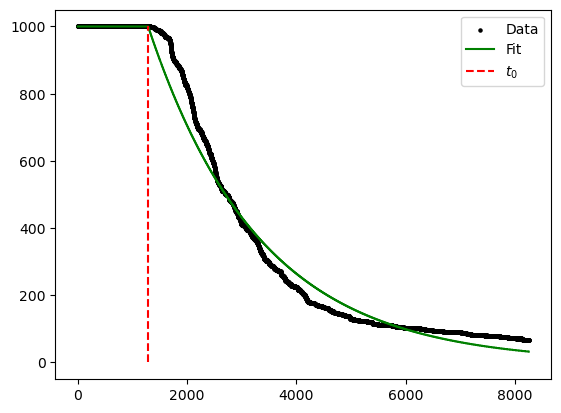

tau = 2040.322147912193 ± 3.874193572060909


In [4]:
t0 = time[particles < 1000][0]
print(f'{t0 = }')

def _exp_decay(t,tau):
    return 1000 * np.exp( - (t - t0) / tau) + 0


def _const_exp_decay(t,tau):
    trel = t - t0
    constant = lambda t: np.full(t.shape,1000)
    exp_function = lambda t: _exp_decay(t,tau)
    function = np.piecewise(t, [trel <= 0, trel > 0],[constant,exp_function])
    return function

def exp_decay_fit(t,tau):#for now we are not fitting on amp or offset
    return _const_exp_decay(t,tau)

popt,pcov = curve_fit(exp_decay_fit,time,particles)

plt.figure()
plt.scatter(time,particles,c='black',label='Data',s=5)
plt.plot(time,_const_exp_decay(time,*popt),label='Fit',c='Green')
plt.vlines(t0,0,1000,colors='red',label=r'$t_0$',linestyles='dashed')
plt.legend()
plt.show()

# print(f"t0 = {popt[0]} ± {np.sqrt(pcov[0,0])}")
print(f"tau = {popt[0]} ± {np.sqrt(pcov[0,0])}")